In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol, expand
import matplotlib.pyplot as plt


import tensorflow as tf

import keras
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential


from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from DeepLie_mods import *

from LieOperator import LieOperator
from Poisson import PoissonBracket
from sympy import Poly
import Factorization
from Factorization import factorization
from Factorization import taylor_to_weight_mat

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [2]:
import random

from IPython.display import HTML


def hide_toggle(for_next=False):
    """
    Method to toggle the visibility
    of a single code input cell in Jupyter.
    Handy to use in combination with RISE for
    preseentations.
    Ref: https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
    """
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + ".next()"

    toggle_text = "Toggle show/hide"  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = (
        ""  # bit of JS to permanently hide code in current cell (only when toggling next cell)
    )

    if for_next:
        target_cell = next_cell
        toggle_text += " next cell"
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = "code_toggle_{}".format(str(random.randint(1, 2 ** 64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}
            {js_hide_current}
        </script>
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current,
        toggle_text=toggle_text,
    )

    return HTML(html)

# We are just using the paraxial approximation for Hamiltonians

$$ H_{drift} = \frac{p_x^2 + p_y^2}{2} $$

$$ H_{quad} = \frac{p_x^2 + p_y^2}{2} + \frac{k_1}{2} (x^2 - y^2) $$

and will be looking at the FODO cell:

$$ \frac{1}{2} QF - D - QD - D - \frac{1}{2} QF$$

# Creating weight matrices using Runge-Kutta (Ivanov)

In [3]:
hide_toggle(for_next=True)

In [4]:
x = Symbol('x')
y = Symbol('y')
px = Symbol('p_x')
py = Symbol('p_y')
J = np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])

def Ivanov_RK(k1,k2,l_d,l_qf,l_qd,_order=1):
    

    exp_order = _order
    integrator_loops = 100


    state = np.array([x,px,y,py])

    drift_rhs = [px,0*x,py,0*y]
    quadf_rhs = [px,-k1*x,py,k1*y]
    quadd_rhs = [px,-k2*x,py,k2*y]



    map_builder_drift = LieMapBuilder(state, drift_rhs, order=exp_order)
    R_drift = map_builder_drift.getInitR()
    R_drift = map_builder_drift.propogate(h=l_d/integrator_loops, N=integrator_loops, verbose=False)

    map_builder_quadf = LieMapBuilder(state, quadf_rhs, order=exp_order)
    R_quadf = map_builder_quadf.getInitR()
    R_quadf = map_builder_quadf.propogate(h=l_qf/integrator_loops, N=integrator_loops, verbose=False)

    map_builder_quadd = LieMapBuilder(state, quadd_rhs, order=exp_order)
    R_quadd = map_builder_quadd.getInitR()
    R_quadd = map_builder_quadd.propogate(h=l_qd/integrator_loops, N=integrator_loops, verbose=False)

    W_drift_RK = map_builder_drift.convert_weights_to_full_nn(R_drift)
    W_quadf_RK = map_builder_quadf.convert_weights_to_full_nn(R_quadf)
    W_quadd_RK = map_builder_quadd.convert_weights_to_full_nn(R_quadd)

#     printlist(W_drift_RK)
#     printlist(W_quadf_RK)
#     printlist(W_quadd_RK)

    dim = 4  # predefined state vector dimension, contains physical parameters of a particle
    order = _order # predefined order of nonlinearity, order of Lie map

    # we have 4 different control elements
    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_RK = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_RK, Drift_RK, QuadD_RK, Drift_RK, QuadF_RK]

    # simply construct a neural network (computatuonal graph)
    fodo_RK = Sequential()
    for el in lattice:
        fodo_RK.add(el)

    Drift_RK.set_weights(W_drift_RK)
    QuadF_RK.set_weights(W_quadf_RK)
    QuadD_RK.set_weights(W_quadd_RK)
    
    
    
    W_drift_RK_corr = [W_drift_RK[0],correct_weigths(W_drift_RK[1])]
    W_quadf_RK_corr = [W_quadf_RK[0],correct_weigths(W_quadf_RK[1])]
    W_quadd_RK_corr = [W_quadd_RK[0],correct_weigths(W_quadd_RK[1])]

    # we have 4 different control elements
    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_RK_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_RK_corr, Drift_RK_corr, QuadD_RK_corr, Drift_RK_corr, QuadF_RK_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_RK_corr = Sequential()
    for el in lattice:
        fodo_RK_corr.add(el)

    Drift_RK_corr.set_weights(W_drift_RK_corr)
    QuadF_RK_corr.set_weights(W_quadf_RK_corr)
    QuadD_RK_corr.set_weights(W_quadd_RK_corr)
    
    return fodo_RK, fodo_RK_corr

# Matrix Multiplication (Simple Linear tracking)

In [5]:
hide_toggle(for_next=True)

In [6]:
def MatrixTracking(k1,k2,l_d,l_qf,l_qd):
    l_drift = l_d
    l_quadf = l_qf
    l_quadd = l_qd

#     k1 = 0.54102/2
#     k2 = -2*k1

    omega = np.sqrt(k1)
    sin = np.sin(omega*l_quadf)
    cos = np.cos(omega*l_quadf)
    sinh = np.sinh(omega * l_quadf)
    cosh = np.cosh(omega * l_quadf)
    Mq = np.array([[cos, sin/omega,0,0],[-omega * sin, cos, 0, 0],[0,0,cosh,sinh/omega],[0,0,omega * sinh, cosh]])

    omega = np.sqrt(k1)
    sin = np.sin(omega*l_quadd)
    cos = np.cos(omega*l_quadd)
    sinh = np.sinh(omega * l_quadd)
    cosh = np.cosh(omega * l_quadd)
    Mqq = np.array([[cosh,sinh/omega,0,0],[omega * sinh, cosh,0,0],[0,0,cos, sin/omega],[0,0,-omega * sin, cos]])


    Md = np.array([[1,l_drift,0,0],[0,1,0,0],[0,0,1,l_drift],[0,0,0,1]])

    M = np.dot(Md,Mq)
    M = np.dot(Mqq,M)
    M = np.dot(Md,M)
    M = np.dot(Mq,M)

    disp = np.array([[0,0,0,0]])

    W_drift_Mat = [disp,Md.T]
    W_quadf_Mat = [disp,Mq.T]
    W_quadd_Mat = [disp,Mqq.T]

    # printlist(W_drift_Mat)
    # printlist(W_quadf_Mat)
    # printlist(W_quadd_Mat)

    dim = 4  # predefined state vector dimension, contains physical parameters of a particle
    order = 1 # predefined order of nonlinearity, order of Lie map

    # we have 4 different control elements
    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_Mat = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_Mat = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_Mat = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_Mat, Drift_Mat, QuadD_Mat, Drift_Mat, QuadF_Mat]

    # simply construct a neural network (computatuonal graph)
    fodo_Mat = Sequential()
    for el in lattice:
        fodo_Mat.add(el)

    Drift_Mat.set_weights(W_drift_Mat)
    QuadF_Mat.set_weights(W_quadf_Mat)
    QuadD_Mat.set_weights(W_quadd_Mat)
    
    return M, fodo_Mat

# Lie Maps cutoff Taylor Series

In [7]:
hide_toggle(for_next=True)

In [8]:
def LieTracking(k1,k2,l_d,l_qf,l_qd,order=2):
    l_drift = l_d
    l_quadf = l_qf
    l_quadd = l_qd

#     k1 = 0.54102/2
#     k2 = -2*k1

    taylor_order = order

    H_drift = l_drift * ((px**2 + py**2)/2)
    H_quadf = l_quadf * ((px**2 + py**2)/2 + k1 * (x**2 - y**2)/2)
    H_quadd = l_quadd * ((px**2 + py**2)/2 + k2 * (x**2 - y**2)/2)

    L_drift = LieOperator(-H_drift,[x,y],[px,py])
    L_quadf = LieOperator(-H_quadf,[x,y],[px,py])
    L_quadd = LieOperator(-H_quadd,[x,y],[px,py])


    taylor_drift = [L_drift.LieMap(x,taylor_order).ham.doit(),L_drift.LieMap(px,taylor_order).ham.doit(),L_drift.LieMap(y,taylor_order).ham.doit(),L_drift.LieMap(py,taylor_order).ham.doit()]

    taylor_quadf = [L_quadf.LieMap(x,taylor_order).ham.doit(),L_quadf.LieMap(px,taylor_order).ham.doit(),L_quadf.LieMap(y,taylor_order).ham.doit(),L_quadf.LieMap(py,taylor_order).ham.doit()]

    taylor_quadd = [L_quadd.LieMap(x,taylor_order).ham.doit(),L_quadd.LieMap(px,taylor_order).ham.doit(),L_quadd.LieMap(y,taylor_order).ham.doit(),L_quadd.LieMap(py,taylor_order).ham.doit()]


    M_taylor_drift = factorization(taylor_drift)
    M_taylor_quadf = factorization(taylor_quadf)
    M_taylor_quadd = factorization(taylor_quadd)
    
#     corr_drift = correct_weights(M_taylor_drift[0])
#     corr_qf = correct_weights(M_taylor_quadf[0])
#     corr_qd = correct_weights(M_taylor_quadd[0])
    
    disp = np.array([[0,0,0,0]])

    W_drift_Lie = [disp,M_taylor_drift[0].T]
    W_quadf_Lie = [disp,M_taylor_quadf[0].T]
    W_quadd_Lie = [disp,M_taylor_quadd[0].T]
    
#     W_drift_Lie_corr = [disp,corr_drift.T]
#     W_quadf_Lie_corr = [disp,corr_qf.T]
#     W_quadd_Lie_corr = [disp,corr_qd.T]


#     printlist(W_drift_Lie)
#     printlist(W_quadf_Lie)
#     printlist(W_quadd_Lie)


    dim = 4  # predefined state vector dimension, contains physical parameters of a particle
    order = 1 # predefined order of nonlinearity, order of Lie map


    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_Lie = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_Lie = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_Lie = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_Lie, Drift_Lie, QuadD_Lie, Drift_Lie, QuadF_Lie]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie = Sequential()
    for el in lattice:
        fodo_Lie.add(el)

    Drift_Lie.set_weights(W_drift_Lie)
    QuadF_Lie.set_weights(W_quadf_Lie)
    QuadD_Lie.set_weights(W_quadd_Lie)
    
    

    W_drift_Lie_corr = [disp,correct_weigths(W_drift_Lie[1])]
    W_quadf_Lie_corr = [disp,correct_weigths(W_quadf_Lie[1])]
    W_quadd_Lie_corr = [disp,correct_weigths(W_quadd_Lie[1])]


    # e.g. QFA helps focusing particle in radial direction, and QDA in vertical one
    Drift_Lie_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadF_Lie_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))
    QuadD_Lie_corr = LieLayer(output_dim = dim, order = order, input_shape = (dim,))

    lattice = [QuadF_Lie_corr, Drift_Lie_corr, QuadD_Lie_corr, Drift_Lie_corr, QuadF_Lie_corr]

    # simply construct a neural network (computatuonal graph)
    fodo_Lie_corr = Sequential()
    for el in lattice:
        fodo_Lie_corr.add(el)

    Drift_Lie_corr.set_weights(W_drift_Lie_corr)
    QuadF_Lie_corr.set_weights(W_quadf_Lie_corr)
    QuadD_Lie_corr.set_weights(W_quadd_Lie_corr)
    
    return fodo_Lie, fodo_Lie_corr

def correct_weigths(M):
    m11 = M[0,0]
    m12 = M[0,1]
    m21 = M[1,0]
    m22 = M[1,1]
    
    error = np.linalg.norm(np.dot(M.T,np.dot(J,M)) - J)
    
    print('Symplectic error: ', error)
                           
    
    if m11*m22 - m12*m21 != 1:
        if m11 != 0:
            m22 = (1+m12*m21)/m11
        elif m21 != 0:
            m12 = (1-m11*m22)/m21
        elif m12 != 0:
            m21 = (1-m11*m22)/m12
        else:
            m11 = 1/m22
    else:
        print("The upper sub-matrix is symplectic.")
        
    m33 = M[2,2]
    m34 = M[2,3]
    m43 = M[3,2]
    m44 = M[3,3]
    
    if m33*m44 - m34*m43 != 1:
        if m33 != 0:
            m44 = (1+m34*m43)/m33
        elif m43 != 0:
            m34 = (1-m33*m44)/m43
        elif m43 != 0:
            m34 = (1-m33*m44)/m43
        else:
            m33 = 1/m44
    else:
        print("The lower sub-matrix is symplectic.")
    
    return np.array([[m11,m12,0,0],[m21,m22,0,0],[0,0,m33,m34],[0,0,m43,m44]])
        

# Deep Lie Network

In [9]:
def TrackFodo(r0,duration=100):
    X_RK = []
    X_Mat = []
    X_Lie = []
    X_Lie_corr = []
    X_RK_corr = []

    X_Exact = []



    for pos in r0:
        X0 = np.array(pos).reshape((-1, 4))
        X_RK.append(X0)
        X_Mat.append(X0)
        X_Lie.append(X0)
        X_Lie_corr.append(X0)
        X_RK_corr.append(X0)
        X_Exact.append(pos)

        for i in range(duration): 
            X_RK.append(fodo_RK.predict(X_RK[-1]))
            X_Mat.append(fodo_Mat.predict(X_Mat[-1]))
            X_Lie.append(fodo_Lie.predict(X_Lie[-1]))
            X_Lie_corr.append(fodo_Lie_corr.predict(X_Lie_corr[-1]))
            X_RK_corr.append(fodo_RK_corr.predict(X_RK_corr[-1]))

            r = np.dot(M,pos)
            X_Exact.append(r)
            pos = np.copy(r)


    X_RK = np.array(X_RK)
    X_Mat = np.array(X_Mat)
    X_Lie = np.array(X_Lie)
    X_Lie_corr = np.array(X_Lie_corr)
    X_RK_corr = np.array(X_RK_corr)
    X_Exact = np.array(X_Exact)
    
    return X_RK, X_Mat, X_Lie, X_Exact, X_Lie_corr, X_RK_corr

In [17]:
#works for truncated Lie maps
_k1 = 0.5
_k2 = -0.5

_ld = 2.5
_lqf = 0.25
_lqd = 0.5



fodo_RK, fodo_RK_corr = Ivanov_RK(_k1,_k2,_ld,_lqf,_lqd,_order=1)
M, fodo_Mat = MatrixTracking(_k1,_k2,_ld,_lqf,_lqd)
fodo_Lie, fodo_Lie_corr = LieTracking(_k1,_k2,_ld,_lqf,_lqd,order=2)

[x p_x y p_y]
[p_x, 0, p_y, 0]
[x p_x y p_y]
[p_x, -0.5*x, p_y, 0.5*y]
[x p_x y p_y]
[p_x, 0.5*x, p_y, -0.5*y]
Symplectic error:  0.0
The upper sub-matrix is symplectic.
The lower sub-matrix is symplectic.
Symplectic error:  0.00010416666674054223
Symplectic error:  0.00041666667147255155
Symplectic error:  0.0
The upper sub-matrix is symplectic.
The lower sub-matrix is symplectic.
Symplectic error:  0.00048828125
Symplectic error:  0.0078125


In [18]:
# _r0 = [[10e-7,0,10e-7,0],
#        [10e-5,0,10e-5,0],
#        [0.25,0,0.25,0],
#        [0.5,0,0.5,0],
#        [1,0,1,0],
#        [1.5,0,1.5,0],
#        [2,0,2,0]]

_r0 = [[10e-7,0,10e-7,0],
       [0.25,0,0.25,0],
       [0.5,0,0.5,0],
       [1,0,1,0],
       [2,0,2,0]]

X_RK, X_Mat, X_Lie, X_Exact, X_Lie_corr, X_RK_corr = TrackFodo(_r0,1000)

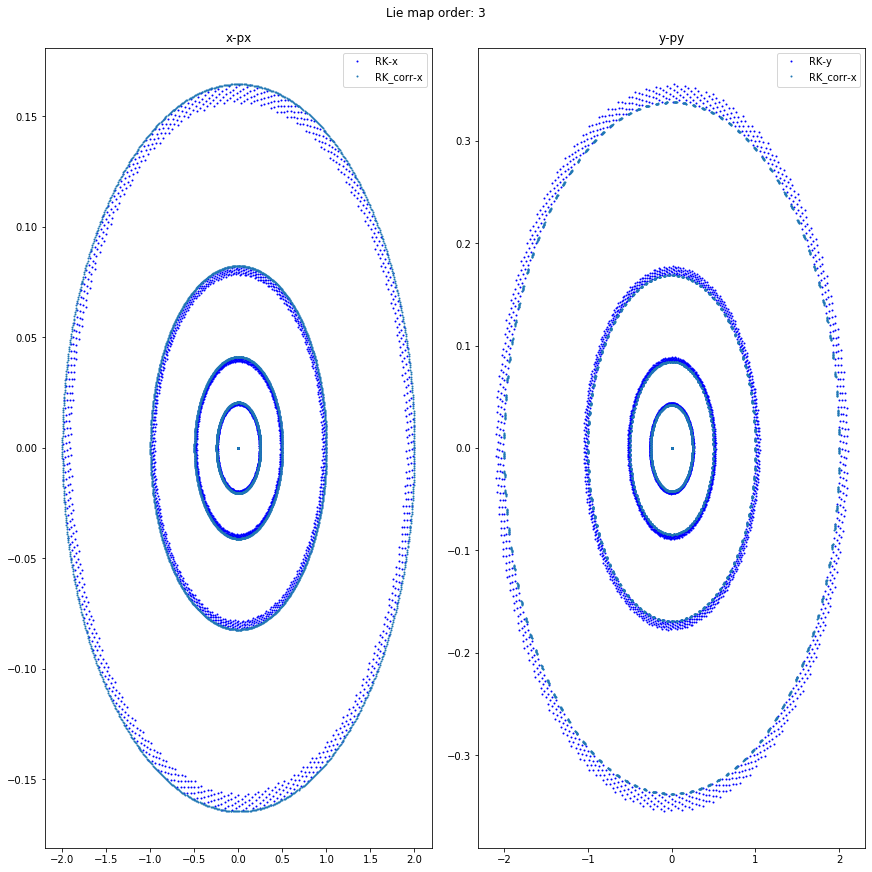

In [23]:
# subplot grid
fig = plt.figure(constrained_layout=True, figsize = (12,12))
gs  = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])


ax1.set_title('x-px')
ax2.set_title('y-py')

ax1.plot(X_RK[:, 0, 0], X_RK[:, 0, 1], 'b.', markersize = 2,label='RK-x') 
ax2.plot(X_RK[:, 0, 2], X_RK[:, 0, 3], 'b.', markersize = 2,label='RK-y')

# ax1.plot(X_Mat[:, 0, 0], X_Mat[:, 0, 1], '.', markersize = 2,label='Matrix-x')
# ax2.plot(X_Mat[:, 0, 2], X_Mat[:, 0, 3], '.', markersize = 2,label='Matrix-x')


# ax1.plot(X_Lie[:, 0, 0], X_Lie[:, 0, 1], '.', markersize = 2,label='Lie-x')
# ax2.plot(X_Lie[:, 0, 2], X_Lie[:, 0, 3], '.', markersize = 2,label='Lie-x')


# ax1.plot(X_Lie_corr[:, 0, 0], X_Lie_corr[:, 0, 1], '.', markersize = 2,label='Lie_corr-x')
# ax2.plot(X_Lie_corr[:, 0, 2], X_Lie_corr[:, 0, 3], '.', markersize = 2,label='Lie_corr-x')

ax1.plot(X_RK_corr[:, 0, 0], X_RK_corr[:, 0, 1], '.', markersize = 2,label='RK_corr-x')
ax2.plot(X_RK_corr[:, 0, 2], X_RK_corr[:, 0, 3], '.', markersize = 2,label='RK_corr-x')

ax1.legend()
ax2.legend()

plt.suptitle("Lie map order: 3")
# plt.savefig('LieMapOrder_3.png')

plt.show()